In [ ]:
# final

In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")
image_path = "/kaggle/input/imggdata/Gemini_Generated_Image_qtq5qzqtq5qzqtq5.png"
yolo_results = model(image_path)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /kaggle/input/imggdata/Gemini_Generated_Image_qtq5qzqtq5qzqtq5.png: 384x640 1 person, 1 train, 316.5ms
Speed: 13.2ms preprocess, 316.5ms inference, 34.2ms postprocess per image at shape (1, 3, 384, 640)


In [3]:
r = yolo_results[0]

boxes = r.boxes.xyxy.cpu().numpy()     # bounding boxes
confs = r.boxes.conf.cpu().numpy()     # confidence
clss  = r.boxes.cls.cpu().numpy()      # class IDs
names = r.names                        # class names


In [4]:
person_boxes = [
    box for box, cls in zip(boxes, clss)
    if names[int(cls)] == "person"
]

person_detected = len(person_boxes) > 0


In [5]:
import cv2
import numpy as np

img = cv2.imread(image_path)
h, w, _ = img.shape

track_mask = np.zeros((h, w), dtype=np.uint8)

# approximate rail corridor (center-bottom)
track_mask[int(h*0.55):h, int(w*0.25):int(w*0.75)] = 1


In [6]:
def overlaps_track(box, mask):
    x1, y1, x2, y2 = map(int, box)
    return mask[y1:y2, x1:x2].sum() > 0

person_on_track = any(overlaps_track(box, track_mask) for box in person_boxes)

In [7]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch

processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
gd_model = AutoModelForZeroShotObjectDetection.from_pretrained(
    "IDEA-Research/grounding-dino-base"
)


E0000 00:00:1768142715.410512      54 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768142715.524683      54 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768142716.447569      54 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768142716.447630      54 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768142716.447634      54 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768142716.447636      54 computation_placer.cc:177] computation placer already registered. Please check linka

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [ ]:
texts = [
    "large stone on railway track",
    "rock obstructing railway rail",
    "object placed on railway track",
    "railway track obstruction",
    "debris on railway track"
]

In [9]:
from PIL import Image

image_pil = Image.open(image_path).convert("RGB")

inputs = processor(images=image_pil, text=texts, return_tensors="pt")

with torch.no_grad():
    outputs = gd_model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    target_sizes=[image_pil.size[::-1]]
)[0]


In [10]:
BOX_THRESHOLD = 0.3

gd_boxes = []
gd_labels = []

for box, score, label in zip(
    results["boxes"], results["scores"], results["labels"]
):
    if score >= BOX_THRESHOLD:
        gd_boxes.append(box.cpu().numpy())
        gd_labels.append(label)


/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


In [11]:
foreign_object_on_track = False

for box in gd_boxes:
    if overlaps_track(box, track_mask):
        foreign_object_on_track = True


In [12]:
tampering = []

if person_on_track:
    tampering.append("Human intrusion on railway track")

if foreign_object_on_track:
    tampering.append("Foreign object placement (stones/debris)")

if not tampering:
    tampering.append("Normal track")

print("🚨 TAMPERING STATUS:")
for t in tampering:
    print("-", t)


🚨 TAMPERING STATUS:
- Human intrusion on railway track
- Foreign object placement (stones/debris)


In [15]:
# ===============================
# VISUALIZATION STARTS HERE
# ===============================

import cv2
import matplotlib.pyplot as plt

img_vis = cv2.imread(image_path)
img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)

# Draw YOLO boxes
for box, cls, conf in zip(boxes, clss, confs):
    label = names[int(cls)]
    if label in ["person", "train"]:
        x1, y1, x2, y2 = map(int, box)
        color = (255, 0, 0) if label == "person" else (0, 255, 0)
        cv2.rectangle(img_vis, (x1,y1), (x2,y2), color, 2)
        cv2.putText(
            img_vis,
            f"{label} {conf:.2f}",
            (x1, y1-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2
        )

# Draw Grounding DINO boxes
for box, label in zip(gd_boxes, gd_labels):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img_vis, (x1,y1), (x2,y2), (0,0,255), 2)
    cv2.putText(
        img_vis,
        label,
        (x1, y1-10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0,0,255),
        2
    )


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2026-01-11 14:57:31--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.118.67, 99.84.118.117, 99.84.118.60, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.118.67|:443... connected.
HTTP request sent, awaiting response... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   295MB/s    in 1.2s    

2026-01-11 14:57:33 (295 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [20]:
from segment_anything import sam_model_registry, SamPredictor
import torch
import numpy as np

# Load SAM ONCE (outside loop ideally)
sam = sam_model_registry["vit_b"](
    checkpoint="sam_vit_b_01ec64.pth"
)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)

predictor.set_image(img_vis)

# Apply SAM only to stone/debris boxes
for box in gd_boxes:
    x1, y1, x2, y2 = map(int, box)

    masks, _, _ = predictor.predict(
        box=np.array([x1, y1, x2, y2]),
        multimask_output=False
    )

    mask = masks[0]
    img_vis[mask] = [255, 0, 0]  # red mask overlay


(np.float64(-0.5), np.float64(2751.5), np.float64(1535.5), np.float64(-0.5))

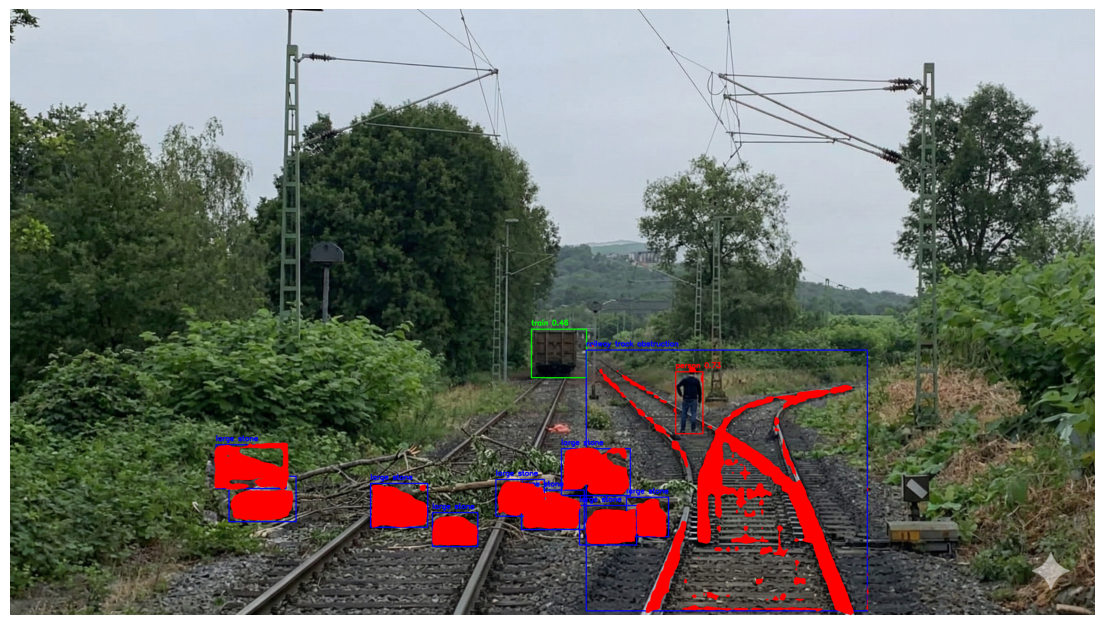

In [21]:
plt.figure(figsize=(14,8))
plt.imshow(img_vis)
plt.axis("off")